This will plot what happens when the travelling wave moves through an area of higher resilience.

In [1]:
import spatialfunctions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

In [27]:
plt.rcParams['font.family'] = 'serif'

# Make plot colors and things to make it easier to be consistent
cmap = plt.cm.get_cmap('Greens').copy()
hatchc = plt.cm.get_cmap('PiYG')(0)
cmap.set_bad('None')#color=plt.cm.get_cmap('PiYG')(0))

# Figsize consistent
figsize = (3,3)

/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_99202/3919438988.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greens').copy()
/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_99202/3919438988.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hatchc = plt.cm.get_cmap('PiYG')(0)


In [3]:
# Set params
s = 0.99
N = 60
c = 1300
al= 0.001
p = 250

# Set up grid to be large enough given the dispersal kernel, but smaller since we don't need as many iterations
xrexp = 17; dx=16;
xr = np.arange(-2**xrexp,2**xrexp+dx,step=dx)

# Consider a range of threshold for the buffer
plist = np.linspace(400,600,9,dtype=int)

# Consider a range of widths for the buffer (in km)
widths = np.linspace(1,4,7)#0,3,base=2,num=4)#np.linspace(1,10,4,dtype=int)

# Get the list of functions. Do this as a dictionary where the keys are the g values
fopt_list = {p:sf.getfopt(p,c)}
for pp in plist:
    fopt_list[pp] = sf.getfopt(pp,c)

In [4]:
# Now simulate

# Number of steps
nt = 200

# Save results to array
wave = np.zeros([len(widths),len(plist),nt+1,N+3,len(xr)])

# Get initial setup
x0 = sf.get_x0even(xrexp,dx,fopt_list[p],c,s,N)

for i,w in enumerate(widths):
    for j,pp in enumerate(plist):
        # Print progress
        print(i+1,"/",len(widths)," ",j+1,"/",len(plist))
        clear_output(wait=True)
        
        # Set up resistance array
        parr = np.ones([len(xr)])*p
        # Buffer zone
        parr[int(2**xrexp/dx):int((2**xrexp+w*1000)/dx)] = pp
        # Make the very end also very high resistance to prevent backward wave
        parr[int((2**xrexp+2**(xrexp-1))/dx)::] = plist[-1]
        # Define f in this case.
        def farr(m,parr):
            return np.array([fopt_list[p](mm) for p,mm in zip(parr,m)])
        
        # Iterate and save
        wave[i,j] = sf.iterate(xr,nt,farr,x0,al,c,s,N,parr=parr)
    # Plot some phi arrays to see if this makes sense
    #plt.plot(xr/1000,parr,c=cmap((i+1)/(len(widths))))
#plt.ylabel(r'Threshold, $\varphi$')
#plt.xlabel('Space (km)')

7 / 7   9 / 9


Text(0.5, 0, 'Space (km)')

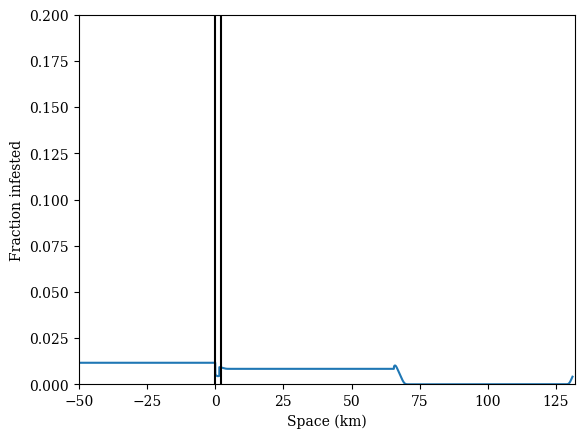

In [5]:
# Visualize at the final time for the smallest barrier and largest just to make sure we aren't colliding
#plt.plot(xr/1000,wave[0,0,-1,N+2]) #This one collides
#plt.plot(xr/1000,wave[-1,-1,-1,N+2])
plt.plot(xr/1000,wave[1,-1,200,N+2])
plt.ylim(0,0.2)
plt.xlim(-50,132)
# Plot buffer zone
plt.axvline(widths[2],c='k')
plt.axvline(0,c='k')
plt.ylabel('Fraction infested')
plt.xlabel('Space (km)')

In [6]:
# Get the time to go through the buffer
timethrubuffer = np.zeros([len(widths),len(plist)])

# Threshold for when it is "through", as eq value
thresh = wave[0,0,0,N+2,0]
for i,w in enumerate(widths):
    for j,pp in enumerate(plist):
        # Check value just beyond buffer
        xloc = ((2**xrexp+w*1000)//dx+1).astype(int)
        timemax = np.argmax(wave[i,j,:,N+2,xloc])
        if wave[i,j,timemax,N+2,xloc] > thresh:
            timethrubuffer[i,j] = timemax
# Mask remaining 0s
timethrubuffer = np.ma.array(timethrubuffer, mask=(timethrubuffer == 0))

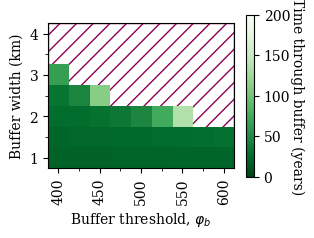

In [33]:
# Plot 
fig,ax = plt.subplots(figsize=(3,3))
# Plot maximum outbreak
col = ax.imshow(timethrubuffer,
                origin='lower',cmap=cmap.reversed(),vmin=0,vmax=200)#np.max([timethrubuffer.max(),150]))
ax.add_patch(Rectangle((-0.5, -0.5), 9, 7, fill=False, hatch='//',edgecolor=hatchc,zorder=-10))
#ax.set_facecolor(c0) 
# Add colorbar
cbar = fig.colorbar(col,ax=ax,shrink=0.7)
cbar.set_label('Time through buffer (years)',rotation=270,labelpad=10)
# Labels
ax.set_xlabel(r'Buffer threshold, $\varphi_b$')
ax.set_ylabel(r'Buffer width (km)')
ax.set_xticks(np.arange(len(plist))[::2],plist[::2],rotation=90)
ax.set_xticks(np.arange(len(plist)-1)[::2]+1,minor=True)
ax.set_yticks(np.arange(len(widths))[::2],widths[::2].astype(int))
ax.set_yticks(np.arange(len(widths)-2)[::2]+1,minor=True)
# Save
fig.savefig('figures/buffer_time.pdf',bbox_inches='tight')